In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import joblib

In [2]:
df = pd.read_csv('D:\\Users\\flammmes\\Downloads\\Book1.csv')
df['d']=df['d'].str.replace(',','')
dfn = pd.read_csv('D:\\Users\\flammmes\\Downloads\\Fluids data.csv')


df.dtypes
dd = df.d.astype('float')
df.d = df.d.astype('float')
df.drop(['Rsob','STO'],axis=1,inplace=True)

x = df.iloc[:,1]/df.iloc[:,8]
mu = 1000*(df.iloc[:,3]*x*x+df.iloc[:,4]*x+df.iloc[:,5])/(df.iloc[:,6]*x+1)
df.insert(9,'μob',mu)
df = df[df['μob']<=50] 


In [3]:
df

,RN,Pb,Pmax,a,b,c,d,Conv,Pref,μob
0,1,8.44608,34.57722,-5.100580e-06,-0.000235,0.002010,-0.135294,1000,1.00000,2.373815
1,2,20.27059,34.47380,-7.688310e-07,-0.000024,0.000294,-0.095071,1000,1.00000,0.538609
2,3,10.26630,34.57722,-1.725490e-06,-0.000107,0.000784,-0.151650,1000,1.00000,0.899221
3,4,11.94172,20.68428,-4.887290e-07,-0.000039,0.000519,-0.085638,1000,1.00000,0.585943
4,5,15.85795,24.13166,-4.220620e-06,0.000008,0.000851,-0.065947,1000,1.00000,1.890544
...,...,...,...,...,...,...,...,...,...,...
585,586,14.34110,34.57720,8.038200e-02,0.227730,0.046789,909.190000,1000,14.34110,0.389920
586,587,4.07480,34.57720,4.518200e-07,-0.000006,0.000443,-0.026531,1000,4.07480,0.450271
587,588,1.61337,34.57720,1.019600e-05,0.000603,0.000604,1.031500,1000,1.61337,0.599496
588,589,15.98890,34.57720,1.822200e-01,0.384390,0.035904,272.240000,1000,15.98890,2.205072


In [4]:
df["μob_cat"] = pd.cut(df["μob"],
                               bins=[0., 5, np.inf],
                               labels=[1, 2])

In [5]:
df["μob_cat"].value_counts()

1    485
2     86
Name: μob_cat, dtype: int64

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=13)
for train_index, test_index in split.split(df, df["μob_cat"]):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]

In [7]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("μob_cat", axis=1, inplace=True)
    #set_.drop("μob", axis=1, inplace=True)
   

C:\Users\flammmes\AppData\Roaming\Python\Python310\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [8]:
df1 = strat_train_set.copy()
df2 = strat_test_set.copy()

In [9]:
df1["μob_cat"] = pd.cut(df1["μob"],
                               bins=[0., 5, np.inf],
                               labels=[1, 2])

In [10]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=13)
for ti, tei in split.split(df1, df1["μob_cat"]):
    strat_tr_set = df1.iloc[ti]
    strat_val_set = df1.iloc[tei]
    

In [11]:
for set_ in (strat_tr_set, strat_val_set):
    set_.drop("μob_cat", axis=1, inplace=True)
    #set_.drop("μob", axis=1, inplace=True)

C:\Users\flammmes\AppData\Roaming\Python\Python310\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [12]:
df_train = strat_tr_set.copy()
df_val = strat_val_set.copy()

In [13]:
def gen_func(a):
    
    dflist = []
    for i in range(len(a)):
        
        instance = a.iloc[i,:].to_numpy(dtype=float)
        P_i=np.linspace(instance[1]+(instance[2]-instance[1])*0.0001,instance[2],num=20)
        x_i = P_i/instance[8]
        mu_i = 1000*(instance[3]*x_i*x_i+instance[4]*x_i+instance[5])/(instance[6]*x_i+1)
        correlations_select = pd.DataFrame({'P':P_i,'μ':mu_i})
        pressure_bubble_point = correlations_select.iloc[0,0]*np.linspace(1,1,20)
        visc_bubble_point = correlations_select.iloc[0,1]*np.linspace(1,1,20)
        correlations_select.insert(0,"Pb",pressure_bubble_point)
        correlations_select.insert(2,'μob',visc_bubble_point)
        dflist.append(correlations_select)
        
    
    totaldf = pd.concat(dflist)
    totaldf.Pb = totaldf.Pb*145.038
    totaldf.P = totaldf.P*145.038
    totaldf.insert(2,'ΔP', totaldf.P-totaldf.Pb)
    #totaldf.drop('P',axis=1,inplace=True)
    return totaldf

In [14]:
test_data = gen_func(df2)
train_data = gen_func(df_train)
val_data = gen_func(df_val)

#y = test_data[test_data.ΔP==0]
#x =  val_data[val_data.ΔP==0]
#train_data = pd.concat([train_data,y,x])
all_data = gen_func(df)

In [15]:

%store all_data

Stored 'all_data' (DataFrame)


In [16]:
for a in [test_data,train_data,val_data,all_data]:
    a.μ = np.sqrt(np.log(a.μ/a.μob+0.0012))
    a.ΔP = np.power(a.ΔP,0.5)
    #a.ΔP = np.log(a.ΔP+1)
    #a.insert(0,'x1',a.ΔP*np.power(a.P/a.Pb,0.2))
    a.μob = a.ΔP*np.power(a.μob,0.07)

    #a.insert(4,'logμob',a.μob*np.log(a.μob))
    a.Pb = a.ΔP/np.log(a.Pb+400)
    a.P = a.ΔP*np.power(a.P,-0.15)


In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

X_train = train_data.drop(["μ"], axis=1) 
y_train = train_data["μ"].copy()
X_val = val_data.drop(["μ"], axis=1) 
y_val = val_data["μ"].copy()
X_test = test_data.drop(["μ"], axis=1) # drop labels for training set
y_test = test_data["μ"].copy()


In [18]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)
X_val_poly = poly_features.fit_transform(X_val)
X_test_poly = poly_features.fit_transform(X_test)
poly_scaler = StandardScaler()
X_train_poly = poly_scaler.fit_transform(X_train_poly)
X_val_poly = poly_scaler.transform(X_val_poly)
X_test_poly = poly_scaler.transform(X_test_poly)


In [19]:
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_val= scaler.transform(X_val)
X_test= scaler.transform(X_test)


In [20]:
X_features = [X_train,X_val,X_test]
X_features_poly = [X_train_poly,X_val_poly,X_test_poly]
y_labels = [y_train,y_val,y_test]

In [21]:
%store X_features
%store X_features_poly
%store y_labels

Stored 'X_features' (list)
Stored 'X_features_poly' (list)
Stored 'y_labels' (list)


In [22]:
gen_func(df_train)

,Pb,P,ΔP,μob,μ
0,1796.527454,1796.527454,0.000000,0.425976,0.425976
1,1796.527454,2071.184401,274.656946,0.425976,0.429562
2,1796.527454,2345.841347,549.313893,0.425976,0.433993
3,1796.527454,2620.498293,823.970839,0.425976,0.439003
4,1796.527454,2895.155240,1098.627785,0.425976,0.444428
...,...,...,...,...,...
15,3225.335953,5822.443437,2597.107485,0.153853,0.188024
16,3225.335953,5995.583936,2770.247984,0.153853,0.190505
17,3225.335953,6168.724435,2943.388483,0.153853,0.193000
18,3225.335953,6341.864934,3116.528982,0.153853,0.195508


In [23]:
totaldf = gen_func(df2)


In [24]:
%store totaldf


Stored 'totaldf' (DataFrame)


In [25]:
dff = gen_func(df)

In [26]:
dff

,Pb,P,ΔP,μob,μ
0,1225.381552,1225.381552,0.000000,2.373815,2.373815
1,1225.381552,1424.835725,199.454173,2.373815,2.403243
2,1225.381552,1624.289897,398.908346,2.373815,2.448862
3,1225.381552,1823.744070,598.362518,2.373815,2.497785
4,1225.381552,2023.198243,797.816691,2.373815,2.547933
...,...,...,...,...,...
15,4560.354725,7287.720024,2727.365299,0.578432,0.628829
16,4560.354725,7469.544377,2909.189653,0.578432,0.633035
17,4560.354725,7651.368730,3091.014006,0.578432,0.637304
18,4560.354725,7833.193084,3272.838359,0.578432,0.641632


In [27]:
corr_matrix = all_data.corr()

In [28]:
corr_matrix["μ"].sort_values(ascending=False)

μ      1.000000
μob    0.893815
Pb     0.881562
P      0.877742
ΔP     0.868450
Name: μ, dtype: float64

array([[<AxesSubplot:xlabel='μ', ylabel='μ'>,
        <AxesSubplot:xlabel='ΔP', ylabel='μ'>,
        <AxesSubplot:xlabel='Pb', ylabel='μ'>,
        <AxesSubplot:xlabel='P', ylabel='μ'>],
       [<AxesSubplot:xlabel='μ', ylabel='ΔP'>,
        <AxesSubplot:xlabel='ΔP', ylabel='ΔP'>,
        <AxesSubplot:xlabel='Pb', ylabel='ΔP'>,
        <AxesSubplot:xlabel='P', ylabel='ΔP'>],
       [<AxesSubplot:xlabel='μ', ylabel='Pb'>,
        <AxesSubplot:xlabel='ΔP', ylabel='Pb'>,
        <AxesSubplot:xlabel='Pb', ylabel='Pb'>,
        <AxesSubplot:xlabel='P', ylabel='Pb'>],
       [<AxesSubplot:xlabel='μ', ylabel='P'>,
        <AxesSubplot:xlabel='ΔP', ylabel='P'>,
        <AxesSubplot:xlabel='Pb', ylabel='P'>,
        <AxesSubplot:xlabel='P', ylabel='P'>]], dtype=object)

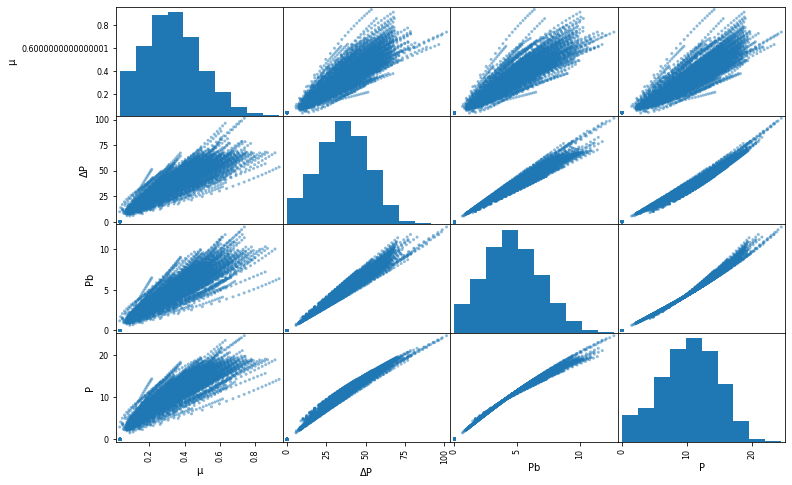

In [29]:
from pandas.plotting import scatter_matrix

attributes = ["μ", 
              "ΔP",'Pb','P']
scatter_matrix(train_data[attributes], figsize=(12, 8))